In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from pandas.plotting import scatter_matrix
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode,  plot
from plotly.graph_objs import *
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score , cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# load dataset and check columns
url = 'https://raw.githubusercontent.com/sartasos/ML-prediction-of-tennis-match-result/main/stats.csv'
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29340 entries, 0 to 29339
Data columns (total 49 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tourney_id          29340 non-null  object 
 1   tourney_name        29340 non-null  object 
 2   surface             29142 non-null  object 
 3   draw_size           29340 non-null  int64  
 4   tourney_level       29340 non-null  object 
 5   tourney_date        29340 non-null  int64  
 6   match_num           29340 non-null  int64  
 7   winner_id           29340 non-null  int64  
 8   winner_seed         12627 non-null  float64
 9   winner_entry        3520 non-null   object 
 10  winner_name         29340 non-null  object 
 11  winner_hand         29324 non-null  object 
 12  winner_ht           25044 non-null  float64
 13  winner_ioc          29340 non-null  object 
 14  winner_age          29336 non-null  float64
 15  loser_id            29340 non-null  int64  
 16  lose

In [3]:
# remove columns with stats that we cannot know before the match (eg "score", "minutes", "l_1stWon" etc)
# also remove columns that we do not need (eg "winner_name","loser_name" etc)
df = df.drop(columns=["score", "tourney_name", "minutes", "l_1stIn", "l_1stWon", "l_2ndWon", "l_ace", "l_svpt",
                      "l_SvGms", "l_bpFaced", "l_df", "l_bpSaved", "w_1stIn", "w_1stWon", "w_2ndWon", "w_ace",
                      "w_svpt", "w_SvGms", "w_bpFaced", "w_df", "w_bpSaved", "winner_name", "loser_name",
                      "winner_entry", "loser_entry", "tourney_id", "match_num", "winner_id", "winner_seed", "loser_id",
                      "loser_seed", "winner_rank", "loser_rank"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29340 entries, 0 to 29339
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   surface             29142 non-null  object 
 1   draw_size           29340 non-null  int64  
 2   tourney_level       29340 non-null  object 
 3   tourney_date        29340 non-null  int64  
 4   winner_hand         29324 non-null  object 
 5   winner_ht           25044 non-null  float64
 6   winner_ioc          29340 non-null  object 
 7   winner_age          29336 non-null  float64
 8   loser_hand          29294 non-null  object 
 9   loser_ht            23151 non-null  float64
 10  loser_ioc           29340 non-null  object 
 11  loser_age           29325 non-null  float64
 12  best_of             29340 non-null  int64  
 13  round               29340 non-null  object 
 14  winner_rank_points  29142 non-null  float64
 15  loser_rank_points   28819 non-null  float64
dtypes: f

In [4]:
# check null values for every column
zero_percent = df.isnull().sum() * 100 / len(df)
zero_values_df = pd.DataFrame({"Feature Name": df.columns, "Zero values count": df.isnull().sum(),
                               "Zero values percent": zero_percent})
print(zero_values_df.reset_index().drop(columns=["index"]))

#there are not many columns with null values, so no action

          Feature Name  Zero values count  Zero values percent
0              surface                198             0.674847
1            draw_size                  0             0.000000
2        tourney_level                  0             0.000000
3         tourney_date                  0             0.000000
4          winner_hand                 16             0.054533
5            winner_ht               4296            14.642127
6           winner_ioc                  0             0.000000
7           winner_age                  4             0.013633
8           loser_hand                 46             0.156783
9             loser_ht               6189            21.094070
10           loser_ioc                  0             0.000000
11           loser_age                 15             0.051125
12             best_of                  0             0.000000
13               round                  0             0.000000
14  winner_rank_points                198             0

In [5]:
# rank points and surface are considered as important features, 
# therefore remove entries that do not contain info about rank points and surface
df.dropna(subset=["winner_rank_points", "loser_rank_points", "surface"], inplace=True)
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28554 entries, 0 to 28553
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   surface             28554 non-null  object 
 1   draw_size           28554 non-null  int64  
 2   tourney_level       28554 non-null  object 
 3   tourney_date        28554 non-null  int64  
 4   winner_hand         28550 non-null  object 
 5   winner_ht           24766 non-null  float64
 6   winner_ioc          28554 non-null  object 
 7   winner_age          28553 non-null  float64
 8   loser_hand          28547 non-null  object 
 9   loser_ht            23015 non-null  float64
 10  loser_ioc           28554 non-null  object 
 11  loser_age           28553 non-null  float64
 12  best_of             28554 non-null  int64  
 13  round               28554 non-null  object 
 14  winner_rank_points  28554 non-null  float64
 15  loser_rank_points   28554 non-null  float64
dtypes: f

In [6]:
# convert "tourney_date" column to new columns of "year" and "month"
df["tourney-year"] = df.tourney_date.astype(str).str[:4].astype(int)        #year column
df["tourney-month"] = df.tourney_date.astype(str).str[4:6].astype(int)      #month column
df = df.drop(columns=["tourney_date"])                                      #remove old tourney_date column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28554 entries, 0 to 28553
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   surface             28554 non-null  object 
 1   draw_size           28554 non-null  int64  
 2   tourney_level       28554 non-null  object 
 3   winner_hand         28550 non-null  object 
 4   winner_ht           24766 non-null  float64
 5   winner_ioc          28554 non-null  object 
 6   winner_age          28553 non-null  float64
 7   loser_hand          28547 non-null  object 
 8   loser_ht            23015 non-null  float64
 9   loser_ioc           28554 non-null  object 
 10  loser_age           28553 non-null  float64
 11  best_of             28554 non-null  int64  
 12  round               28554 non-null  object 
 13  winner_rank_points  28554 non-null  float64
 14  loser_rank_points   28554 non-null  float64
 15  tourney-year        28554 non-null  int32  
 16  tour

In [7]:
# transform our data so that we have 2 players (first & second),their personal information (hand, age, etc)
# and general information about the match and the tourney. 


df = df.rename(columns={"loser_age": "first_age", "loser_hand": "first_hand", "loser_ht": "first_ht", "loser_ioc": "first_ioc",
                        "loser_rank_points": "first_rank_points",
                        "winner_age": "second_age",  "winner_hand": "second_hand", "winner_ht": "second_ht",
                        "winner_ioc": "second_ioc", "winner_rank_points": "second_rank_points"
                        })

# then create 2nd copy with inverse positions
copy_2_df = df.copy()
copy_2_df[['first_age','first_hand','first_ht','first_ioc','first_rank_points',
            'second_age','second_hand','second_ht','second_ioc','second_rank_points']]\
=copy_2_df[['second_age','second_hand','second_ht','second_ioc','second_rank_points',
             'first_age','first_hand','first_ht','first_ioc','first_rank_points']]


# finally create a column "label" in each copy which is equal to 0 if first player wins, or 1 if second player wins

winner_player1 = np.zeros(copy_2_df.shape[0])  # if 1st player wins then label = 0
copy_2_df['label'] = winner_player1

winner_player2 = np.ones(df.shape[0])  #if 2nd player wins then label = 1
df['label'] = winner_player2

# merge the two copies
df = pd.concat([df,copy_2_df])

# shuffle data
df = df.sample(frac=1).reset_index(drop=True) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57108 entries, 0 to 57107
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   surface             57108 non-null  object 
 1   draw_size           57108 non-null  int64  
 2   tourney_level       57108 non-null  object 
 3   second_hand         57097 non-null  object 
 4   second_ht           47781 non-null  float64
 5   second_ioc          57108 non-null  object 
 6   second_age          57106 non-null  float64
 7   first_hand          57097 non-null  object 
 8   first_ht            47781 non-null  float64
 9   first_ioc           57108 non-null  object 
 10  first_age           57106 non-null  float64
 11  best_of             57108 non-null  int64  
 12  round               57108 non-null  object 
 13  second_rank_points  57108 non-null  float64
 14  first_rank_points   57108 non-null  float64
 15  tourney-year        57108 non-null  int32  
 16  tour

In [8]:
# height columns have some null values, so we will fill those values with the columns' mean
df['second_ht'] = df['second_ht'].fillna(df['second_ht'].mean())
df['first_ht'] = df['first_ht'].fillna(df['first_ht'].mean())

#remove missing values
df = df.dropna()

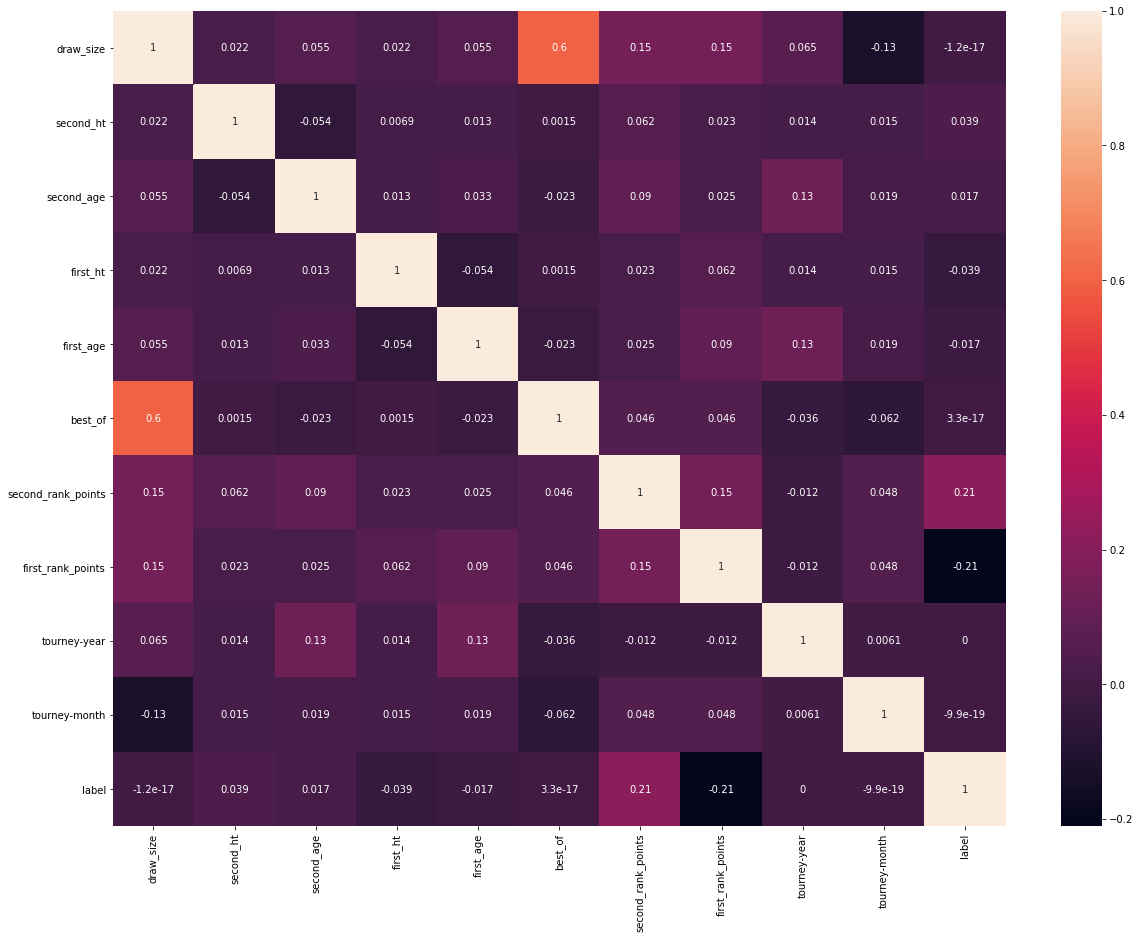

In [9]:
# show correlations

correlations = df.corr()
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [10]:
df.info()

# use pandas.get_dummies to turn columns with categorical values to numerical
dataset1 = pd.get_dummies(df['second_hand'] , drop_first=True)
dataset2 = pd.get_dummies(df['first_hand'], drop_first=True)
dataset3 = pd.get_dummies(df['second_ioc'], drop_first=True)
dataset4 = pd.get_dummies(df['first_ioc'], drop_first=True)
dataset5 = pd.get_dummies(df['surface'], drop_first=True)
dataset6 = pd.get_dummies(df['tourney_level'], drop_first=True)
dataset7 = pd.get_dummies(df['round'], drop_first=True)

# merge the two datasets
merged = pd.concat([df,dataset1,dataset2,dataset3,dataset4,dataset5,dataset6,dataset7],axis='columns' )

# remove old columns with categorical values
df = merged.drop(['second_hand','first_hand','second_ioc','first_ioc','surface','tourney_level','round'], axis='columns')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57082 entries, 0 to 57107
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   surface             57082 non-null  object 
 1   draw_size           57082 non-null  int64  
 2   tourney_level       57082 non-null  object 
 3   second_hand         57082 non-null  object 
 4   second_ht           57082 non-null  float64
 5   second_ioc          57082 non-null  object 
 6   second_age          57082 non-null  float64
 7   first_hand          57082 non-null  object 
 8   first_ht            57082 non-null  float64
 9   first_ioc           57082 non-null  object 
 10  first_age           57082 non-null  float64
 11  best_of             57082 non-null  int64  
 12  round               57082 non-null  object 
 13  second_rank_points  57082 non-null  float64
 14  first_rank_points   57082 non-null  float64
 15  tourney-year        57082 non-null  int32  
 16  tour

class 0: 28541
class 1: 28541


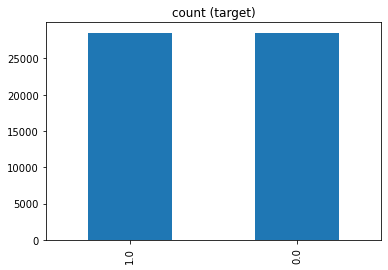

In [11]:
# check how labels are distributed in our dataset
class_count_01, class_count_02 = df['label'].value_counts()
df['label'].value_counts().plot(kind='bar', title='count (target)')
print('class 0:', class_count_02)
print('class 1:', class_count_01)

In [ ]:
################## HISTOGRAMS ##################
'''
hist_data = [df['second_rank_points']]
group_labels = ['second_rank_points'] 
fig = ff.create_distplot(hist_data, group_labels)
fig.show()

hist_data = [df['first_rank_points']]
group_labels = ['first_rank_points'] 
fig = ff.create_distplot(hist_data, group_labels)
fig.show()

hist_data = [df['second_ht']]
group_labels = ['second_ht'] 
fig = ff.create_distplot(hist_data, group_labels)
fig.show()

hist_data = [df['first_ht']]
group_labels = ['first_ht']
fig = ff.create_distplot(hist_data, group_labels)
fig.show()

hist_data = [df['second_age']]
group_labels = ['second_age'] 
fig = ff.create_distplot(hist_data, group_labels)
fig.show()

hist_data = [df['first_age']]
group_labels = ['first_age'] 
fig = ff.create_distplot(hist_data, group_labels)
fig.show()
'''

In [12]:
# train-test split to fit and evaluate our models
y = df['label'].values
X = df.drop(['label'],axis='columns').values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)  #, random_state = 0)

# standardize features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [13]:
################## Naive Bayes ####################################

gaussian_classifier = GaussianNB()
gaussian_classifier.fit(X_train, y_train)

y_pred = gaussian_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score:\n", acc)
print("Training set score: {:.3f}".format(gaussian_classifier.score(X_train,y_train)))
print("Test set score: {:.3f}".format(gaussian_classifier.score(X_test,y_test)))

report = classification_report(y_test,y_pred)  
print(report)

gaussian_classifier.class_count_
gaussian_classifier.classes_
gaussian_classifier.epsilon_
gaussian_classifier.theta_

Confusion Matrix:
 [[3815 1899]
 [2897 2806]]
Accuracy Score:
 0.5799246737321538
Training set score: 0.599
Test set score: 0.580
              precision    recall  f1-score   support

         0.0       0.57      0.67      0.61      5714
         1.0       0.60      0.49      0.54      5703

    accuracy                           0.58     11417
   macro avg       0.58      0.58      0.58     11417
weighted avg       0.58      0.58      0.58     11417



array([[-2.70749512e-03, -3.75152217e-02, -1.29524873e-02,
         4.22411493e-02,  1.82798075e-02, -3.42669793e-03,
        -2.11601691e-01,  2.15544559e-01, -1.57148640e-03,
         1.58175814e-03, -2.45812995e-02,  4.65124400e-02,
         2.65499802e-02, -4.99665834e-02,  1.21312346e-03,
        -3.06560353e-03,  1.70347443e-02, -7.77165473e-03,
        -3.81727351e-03,  4.02460013e-03,  8.83525439e-04,
         4.36363132e-03,  8.47485894e-03,  2.29749617e-02,
        -1.61726261e-02, -1.04944421e-02,  1.26551383e-03,
         2.02164042e-02,  1.51653338e-02,  4.68190130e-03,
        -1.66078443e-02, -5.63462826e-03, -1.51290682e-02,
         5.00637571e-03,  6.35176289e-03,  1.12741340e-02,
         1.21610268e-02, -5.36535855e-03, -4.33329175e-02,
         9.68355634e-03,  7.02124897e-03, -5.69543745e-03,
        -2.99420147e-02,  1.50629393e-03,  2.16928146e-02,
        -9.56400637e-03,  4.41868211e-03,  2.76201656e-06,
         2.70445816e-03,  3.05624550e-03,  5.13533740e-0

In [14]:
# try naive bayes using kfold

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

kfold = KFold(n_splits=10) #, random_state=7)
result1 = cross_val_score(gaussian_classifier, X, y, cv=kfold, scoring='f1')
result2 = cross_val_score(gaussian_classifier, X, y, cv=kfold, scoring='recall')
result3 = cross_val_score(gaussian_classifier, X, y, cv=kfold, scoring='precision')
print("Mean F1 Score = %.2f%% - SD F1 Score = %.2f%%" % (result1.mean()*100, result1.std()*100 ))  
print("Mean Recall Score = %.2f%% - SD Recall = %.2f%%" % (result2.mean()*100, result2.std()*100 ))
print("Mean Precision Score = %.2f%% - SD Precision = %.2f%%" % (result3.mean()*100, result3.std()*100 ))

Mean F1 Score = 59.94% - SD F1 Score = 0.81%
Mean Recall Score = 59.97% - SD Recall = 1.06%
Mean Precision Score = 59.93% - SD Precision = 1.08%


In [ ]:
################## SVM ######################################
'''
svm_classifier = SVC(kernel = 'linear', random_state = 0)
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score:\n", acc)
print("Training set score: {:.3f}".format(svm_classifier.score(X_train,y_train)))
print("Test set score: {:.3f}".format(svm_classifier.score(X_test,y_test)))

report = classification_report(y_test,y_pred)  
print(report)
'''

In [ ]:
# try SVM using kfold
'''
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

kfold = KFold(n_splits=10) #, random_state=7)
result1 = cross_val_score(svm_classifier, X, y, cv=kfold, scoring='f1')
result2 = cross_val_score(svm_classifier, X, y, cv=kfold, scoring='recall')
result3 = cross_val_score(svm_classifier, X, y, cv=kfold, scoring='precision')
print("Mean F1 Score = %.2f%% - SD F1 Score = %.2f%%" % (result1.mean()*100, result1.std()*100 ))  
print("Mean Recall Score = %.2f%% - SD Recall = %.2f%%" % (result2.mean()*100, result2.std()*100 ))
print("Mean Precision Score = %.2f%% - SD Precision = %.2f%%" % (result3.mean()*100, result3.std()*100 ))
'''

In [15]:
################## Decision Tree #####################################

dtree_classifier = DecisionTreeClassifier(criterion = 'entropy')
dtree_classifier.fit(X_train, y_train)

y_pred = dtree_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score:\n", acc)
print("Training set score: {:.3f}".format(dtree_classifier.score(X_train,y_train)))
print("Test set score: {:.3f}".format(dtree_classifier.score(X_test,y_test)))

report = classification_report(y_test,y_pred)  
print(report)

Confusion Matrix:
 [[3380 2334]
 [2389 3314]]
Accuracy Score:
 0.5863186476307262
Training set score: 1.000
Test set score: 0.586
              precision    recall  f1-score   support

         0.0       0.59      0.59      0.59      5714
         1.0       0.59      0.58      0.58      5703

    accuracy                           0.59     11417
   macro avg       0.59      0.59      0.59     11417
weighted avg       0.59      0.59      0.59     11417



In [16]:
# try Decision Tree using kfold
kfold = KFold(n_splits=10) #, random_state=7)
result1 = cross_val_score(dtree_classifier, X, y, cv=kfold, scoring='f1')
result2 = cross_val_score(dtree_classifier, X, y, cv=kfold, scoring='recall')
result3 = cross_val_score(dtree_classifier, X, y, cv=kfold, scoring='precision')
print("Mean F1 Score = %.2f%% - SD F1 Score = %.2f%%" % (result1.mean()*100, result1.std()*100 ))  
print("Mean Recall Score = %.2f%% - SD Recall = %.2f%%" % (result2.mean()*100, result2.std()*100 ))
print("Mean Precision Score = %.2f%% - SD Precision = %.2f%%" % (result3.mean()*100, result3.std()*100 ))

Mean F1 Score = 58.80% - SD F1 Score = 0.72%
Mean Recall Score = 59.05% - SD Recall = 1.02%
Mean Precision Score = 58.99% - SD Precision = 0.75%


In [17]:
################## Random Forest ######################################

rf_classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score:\n", acc)
print("Training set score: {:.3f}".format(rf_classifier.score(X_train,y_train)))
print("Test set score: {:.3f}".format(rf_classifier.score(X_test,y_test)))

#Analyze the results of Random Forest
report = classification_report(y_test,y_pred)  
print(report)

Confusion Matrix:
 [[4008 1706]
 [2594 3109]]
Accuracy Score:
 0.6233686607690286
Training set score: 0.986
Test set score: 0.623
              precision    recall  f1-score   support

         0.0       0.61      0.70      0.65      5714
         1.0       0.65      0.55      0.59      5703

    accuracy                           0.62     11417
   macro avg       0.63      0.62      0.62     11417
weighted avg       0.63      0.62      0.62     11417



In [18]:
# try Random Forest using kfold
kfold = KFold(n_splits=10) #, random_state=7)
result1 = cross_val_score(rf_classifier, X, y, cv=kfold, scoring='f1')
result2 = cross_val_score(rf_classifier, X, y, cv=kfold, scoring='recall')
result3 = cross_val_score(rf_classifier, X, y, cv=kfold, scoring='precision')
print("Mean F1 Score = %.2f%% - SD F1 Score = %.2f%%" % (result1.mean()*100, result1.std()*100 ))  
print("Mean Recall Score = %.2f%% - SD Recall = %.2f%%" % (result2.mean()*100, result2.std()*100 ))
print("Mean Precision Score = %.2f%% - SD Precision = %.2f%%" % (result3.mean()*100, result3.std()*100 ))

Mean F1 Score = 60.06% - SD F1 Score = 0.70%
Mean Recall Score = 55.57% - SD Recall = 1.06%
Mean Precision Score = 65.36% - SD Precision = 0.89%


In [19]:
################## XG Boost ######################################################

xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score:\n", acc)
print("Training set score: {:.3f}".format(xgb_classifier.score(X_train,y_train)))
print("Test set score: {:.3f}".format(xgb_classifier.score(X_test,y_test)))

report = classification_report(y_test,y_pred)  
print(report)

Confusion Matrix:
 [[3689 2025]
 [1935 3768]]
Accuracy Score:
 0.653148813173338
Training set score: 0.678
Test set score: 0.653
              precision    recall  f1-score   support

         0.0       0.66      0.65      0.65      5714
         1.0       0.65      0.66      0.66      5703

    accuracy                           0.65     11417
   macro avg       0.65      0.65      0.65     11417
weighted avg       0.65      0.65      0.65     11417



In [20]:
# try XGBoost using kfold
kfold = KFold(n_splits=10) #, random_state=7)
result1 = cross_val_score(xgb_classifier, X, y, cv=kfold, scoring='f1')
result2 = cross_val_score(xgb_classifier, X, y, cv=kfold, scoring='recall')
result3 = cross_val_score(xgb_classifier, X, y, cv=kfold, scoring='precision')
print("Mean F1 Score = %.2f%% - SD F1 Score = %.2f%%" % (result1.mean()*100, result1.std()*100 ))  
print("Mean Recall Score = %.2f%% - SD Recall = %.2f%%" % (result2.mean()*100, result2.std()*100 ))
print("Mean Precision Score = %.2f%% - SD Precision = %.2f%%" % (result3.mean()*100, result3.std()*100 ))

Mean F1 Score = 66.64% - SD F1 Score = 0.54%
Mean Recall Score = 66.62% - SD Recall = 0.76%
Mean Precision Score = 66.68% - SD Precision = 0.85%


In [21]:
################## K-Nearest Neighbors ###########################################

knn_classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
knn_classifier .fit(X_train, y_train)

y_pred = knn_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
acc = accuracy_score(y_test, y_pred)
print("Accuracy Score:\n", acc)
print("Training set score: {:.3f}".format(knn_classifier.score(X_train,y_train)))
print("Test set score: {:.3f}".format(knn_classifier.score(X_test,y_test)))

report = classification_report(y_test,y_pred)  
print(report)

Confusion Matrix:
 [[3256 2458]
 [2527 3176]]
Accuracy Score:
 0.5633704125426995
Training set score: 0.726
Test set score: 0.563
              precision    recall  f1-score   support

         0.0       0.56      0.57      0.57      5714
         1.0       0.56      0.56      0.56      5703

    accuracy                           0.56     11417
   macro avg       0.56      0.56      0.56     11417
weighted avg       0.56      0.56      0.56     11417



In [22]:
# try KNN using kfold
kfold = KFold(n_splits=10) #, random_state=7)
result1 = cross_val_score(knn_classifier, X, y, cv=kfold, scoring='f1')
result2 = cross_val_score(knn_classifier, X, y, cv=kfold, scoring='recall')
result3 = cross_val_score(knn_classifier, X, y, cv=kfold, scoring='precision')
print("Mean F1 Score = %.2f%% - SD F1 Score = %.2f%%" % (result1.mean()*100, result1.std()*100 ))  
print("Mean Recall Score = %.2f%% - SD Recall = %.2f%%" % (result2.mean()*100, result2.std()*100 ))
print("Mean Precision Score = %.2f%% - SD Precision = %.2f%%" % (result3.mean()*100, result3.std()*100 ))

Mean F1 Score = 61.61% - SD F1 Score = 0.59%
Mean Recall Score = 61.54% - SD Recall = 0.73%
Mean Precision Score = 61.70% - SD Precision = 1.07%
